# Data Center Cost Analysis

This notebook performs the full assignment:

1. Data Cleaning & Feature Engineering
2. Machine Learning Modeling
3. Visualization & Reporting

## Task 1: Data Cleaning & Feature Engineering

- Simulate dataset
- Remove missing values and outliers
- Create `high_utilization` flag
- Aggregate by day and server
- Save to `daily_summary.csv`

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from scipy.stats import zscore

# Simulate data
n_servers = 10
n_records = 5000
start_date = datetime(2025, 1, 1)
timestamps = [start_date + timedelta(hours=np.random.randint(0, 24*30)) for _ in range(n_records)]
server_ids = [f"server_{np.random.randint(1, n_servers+1)}" for _ in range(n_records)]
cpu_usage = np.random.uniform(10, 90, n_records)
memory_usage = np.random.uniform(20, 95, n_records)
disk_io = np.random.uniform(0.1, 1.5, n_records)
network_io = np.random.uniform(0.05, 2.0, n_records)
power_kwh = cpu_usage * 0.5 + memory_usage * 0.2 + np.random.normal(0, 5, n_records)
cost_per_kwh = np.random.uniform(0.10, 0.20, n_records)
cooling_cost = power_kwh * 0.1
total_cost = power_kwh * cost_per_kwh + cooling_cost

df = pd.DataFrame({
    "timestamp": timestamps,
    "server_id": server_ids,
    "cpu_usage": cpu_usage,
    "memory_usage": memory_usage,
    "disk_io": disk_io,
    "network_io": network_io,
    "power_kwh": power_kwh,
    "cost_per_kwh": cost_per_kwh,
    "cooling_cost": cooling_cost,
    "total_cost": total_cost
})

In [7]:
# Clean data
df_clean = df.dropna()
for col in ["cpu_usage", "memory_usage", "total_cost"]:
    df_clean = df_clean[(np.abs(zscore(df_clean[col])) < 3)]

# Feature engineering
df_clean["high_utilization"] = ((df_clean["cpu_usage"] > 80) | (df_clean["memory_usage"] > 90)).astype(int)
df_clean["date"] = df_clean["timestamp"].dt.floor("D")
daily_summary = df_clean.groupby(["date", "server_id"]).agg(
    avg_cpu=("cpu_usage", "mean"),
    avg_memory=("memory_usage", "mean"),
    total_power=("power_kwh", "sum"),
    total_cost=("total_cost", "sum"),
    high_util_days=("high_utilization", "sum")
).reset_index()

daily_summary.to_csv("daily_summary.csv", index=False)
daily_summary.head()

,date,server_id,avg_cpu,avg_memory,total_power,total_cost,high_util_days
0,2025-01-01,server_1,43.976591,52.720341,351.993210,91.284722,3
1,2025-01-01,server_10,54.170059,63.547956,737.780898,190.284461,7
2,2025-01-01,server_2,52.070892,60.856460,628.156261,148.439428,3
3,2025-01-01,server_3,57.671230,55.989216,926.840069,230.935927,6
4,2025-01-01,server_4,51.270544,60.829166,756.140389,197.894097,5


In [8]:
daily_summary

,date,server_id,avg_cpu,avg_memory,total_power,total_cost,high_util_days
0,2025-01-01,server_1,43.976591,52.720341,351.993210,91.284722,3
1,2025-01-01,server_10,54.170059,63.547956,737.780898,190.284461,7
2,2025-01-01,server_2,52.070892,60.856460,628.156261,148.439428,3
3,2025-01-01,server_3,57.671230,55.989216,926.840069,230.935927,6
4,2025-01-01,server_4,51.270544,60.829166,756.140389,197.894097,5
...,...,...,...,...,...,...,...
295,2025-01-30,server_5,45.627522,54.703288,612.167016,150.347429,4
296,2025-01-30,server_6,42.793205,65.570572,589.117464,137.915793,3
297,2025-01-30,server_7,51.778587,56.893620,619.178022,157.366888,3
298,2025-01-30,server_8,53.458224,55.540943,258.556007,63.682133,1


## Task 2: Machine Learning Modeling

- Prepare lag features to predict next-day total cost per server
- Train/Test split by date
- Compare Linear Regression and Random Forest
- Evaluate with MAE, RMSE, R²

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Prepare lag features
daily_summary = daily_summary.sort_values(["server_id", "date"])
daily_summary["prev_avg_cpu"] = daily_summary.groupby("server_id")["avg_cpu"].shift(1)
daily_summary["prev_avg_memory"] = daily_summary.groupby("server_id")["avg_memory"].shift(1)
daily_summary["prev_total_power"] = daily_summary.groupby("server_id")["total_power"].shift(1)
daily_summary["prev_high_util_days"] = daily_summary.groupby("server_id")["high_util_days"].shift(1)
daily_summary = daily_summary.dropna()

features = ["prev_avg_cpu", "prev_avg_memory", "prev_total_power", "prev_high_util_days"]
X = daily_summary[features]
y = daily_summary["total_cost"]

# Train/Test split
unique_dates = sorted(daily_summary["date"].unique())
split_idx = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_idx]
test_dates = unique_dates[split_idx:]

X_train = X[daily_summary["date"].isin(train_dates)]
X_test = X[daily_summary["date"].isin(test_dates)]
y_train = y[daily_summary["date"].isin(train_dates)]
y_test = y[daily_summary["date"].isin(test_dates)]

# Models
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42)
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    results.append((name, mae, rmse, r2))
    
import pandas as pd
pd.DataFrame(results, columns=["Model", "MAE", "RMSE", "R2"])

,Model,MAE,RMSE,R2
0,LinearRegression,32.128199,1522.048707,-0.042894
1,RandomForest,32.761647,1549.902249,-0.061979


## Task 3: Visualization & Reporting

- Plot time series of total cost for a sample server
- Heatmap of avg CPU vs Memory by server
- Bar chart comparing MAE & RMSE

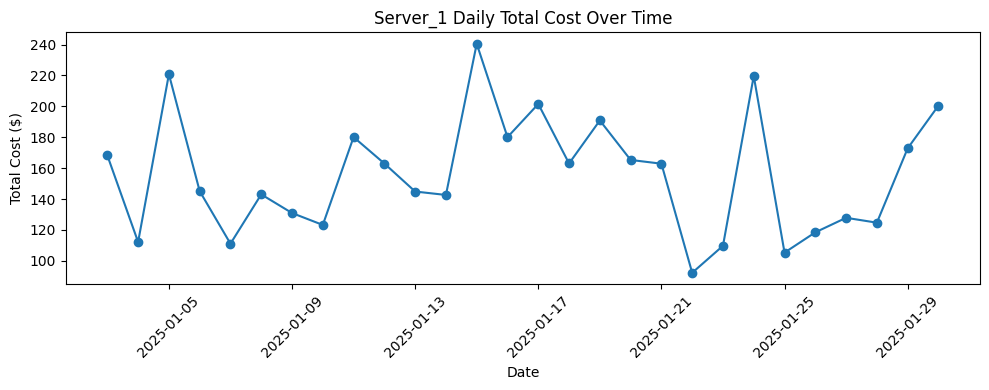

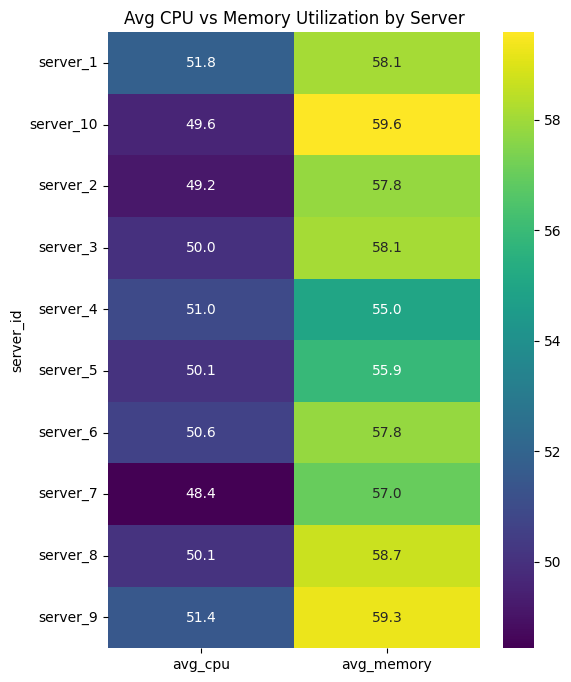

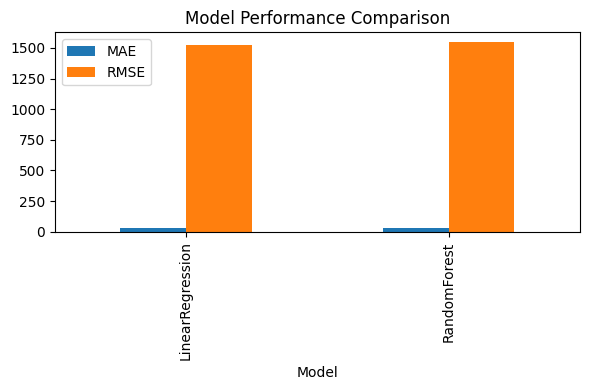

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Time series for server_1
server1 = daily_summary[daily_summary["server_id"] == "server_1"]
plt.figure(figsize=(10,4))
plt.plot(server1["date"], server1["total_cost"], marker="o")
plt.title("Server_1 Daily Total Cost Over Time")
plt.xlabel("Date")
plt.ylabel("Total Cost ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Heatmap of avg CPU vs memory
pivot = daily_summary.groupby("server_id")[["avg_cpu", "avg_memory"]].mean()
plt.figure(figsize=(6,8))
sns.heatmap(pivot, annot=True, fmt=".1f", cmap="viridis")
plt.title("Avg CPU vs Memory Utilization by Server")
plt.show()

# Performance comparison bar chart
perf_df = pd.DataFrame(results, columns=["Model", "MAE", "RMSE", "R2"]).set_index("Model")
perf_df[["MAE", "RMSE"]].plot(kind="bar", figsize=(6,4))
plt.title("Model Performance Comparison")
plt.tight_layout()
plt.show()